In [6]:
# In your new notebook: 02_Stability_Map.ipynb

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import our model from the .py file
from predator_prey_model import PredatorPreyChemostat

# <<< ADD THIS LINE >>>
# Import the solver function that we call directly in this notebook
from scipy.integrate import solve_ivp

# # Define a helper function to classify the simulation outcome
# def classify_outcome(results, predator_extinction_threshold=1e-3, equilibrium_tolerance=0.05):
#     """
#     Analyzes the final state of a simulation and classifies it.
#     Returns an integer code for the outcome.
#     """
#     # ... (rest of the function is the same)
#     if not results or np.any(np.isnan(results['Total_Bifurcation'])):
#         return 0 # Failure / Extinction

#     # Check the last 25% of the time series for stability
#     final_predator_series = results['Total_Brachionus'][-len(results['Total_Brachionus'])//4:]
    
#     if np.mean(final_predator_series) < predator_extinction_threshold:
#         return 0 # Extinction
    
#     max_val = np.max(final_predator_series)
#     min_val = np.min(final_predator_series)
    
#     # Using relative difference to check for equilibrium
#     if max_val > 0 and (max_val - min_val) / max_val < equilibrium_tolerance:
#         return 1 # Stable Equilibrium
#     elif max_val == 0 and min_val == 0:
#         return 1 # Stable at zero
#     else:
#         return 2 # Oscillations / Chaos


# In the first cell of 02_Stability_Map.ipynb, replace the old function with this one.

def classify_outcome(results, predator_extinction_threshold=1e-3, equilibrium_tolerance=0.05):
    """
    Analyzes the final state of a simulation and classifies it.
    Returns an integer code for the outcome.
    """
    # <<< THIS LINE IS FIXED >>>
    if not results or np.any(np.isnan(results['Total_Brachionus'])):
        return 0 # Failure / Extinction

    # Check the last 25% of the time series for stability
    final_predator_series = results['Total_Brachionus'][-len(results['Total_Brachionus'])//4:]
    
    if np.mean(final_predator_series) < predator_extinction_threshold:
        return 0 # Extinction
    
    max_val = np.max(final_predator_series)
    min_val = np.min(final_predator_series)
    
    # Using relative difference to check for equilibrium
    # Also added a check to prevent division by zero if max_val is 0
    if max_val > 0 and (max_val - min_val) / max_val < equilibrium_tolerance:
        return 1 # Stable Equilibrium
    elif max_val == 0 and min_val == 0:
        return 1 # Stable at zero (extinct)
    else:
        return 2 # Oscillations / Chaos

In [7]:
# --- Simulation Parameters ---
grid_resolution = 50 # Start with a lower value (e.g., 20) to test, then increase (e.g., 100) for final plot
delta_range = np.linspace(0.1, 1.5, grid_resolution)
Ni_range = np.linspace(20, 500, grid_resolution)

# A 2D array to store the results of our classification
stability_map = np.zeros((grid_resolution, grid_resolution))

# --- Initial Conditions and Time ---
initial_conditions = [60.0, 10.0, 5.0, 5.0]
t_transient = (0, 1000) # Time to let the system settle
t_measure = (1000, 1500) # Time over which we measure the behavior
t_eval_measure = np.linspace(t_measure[0], t_measure[1], 500)

# --- The Main Loop ---
for i, Ni in enumerate(tqdm(Ni_range, desc="Ni Progress")):
    for j, delta in enumerate(delta_range):
        # Create the system
        system = PredatorPreyChemostat(delta=delta, Ni=Ni)
        
        # Run a long simulation to get to the attractor
        # We only need the final state, so we don't need t_eval here
        transient_sol = solve_ivp(system._model_equations, t_transient, initial_conditions, method='LSODA')
        
        # Check if the transient simulation succeeded
        if transient_sol.status != 0:
            stability_map[i, j] = 0 # Mark as extinction/failure
            continue
            
        # Start the measurement run from the final state of the transient run
        measure_ic = transient_sol.y[:, -1]
        results = system.run_simulation(measure_ic, t_measure, t_eval_measure)
        
        # Classify the outcome and store it in our map
        outcome = classify_outcome(results)
        stability_map[i, j] = outcome

Ni Progress:   0%|          | 0/50 [00:00<?, ?it/s]

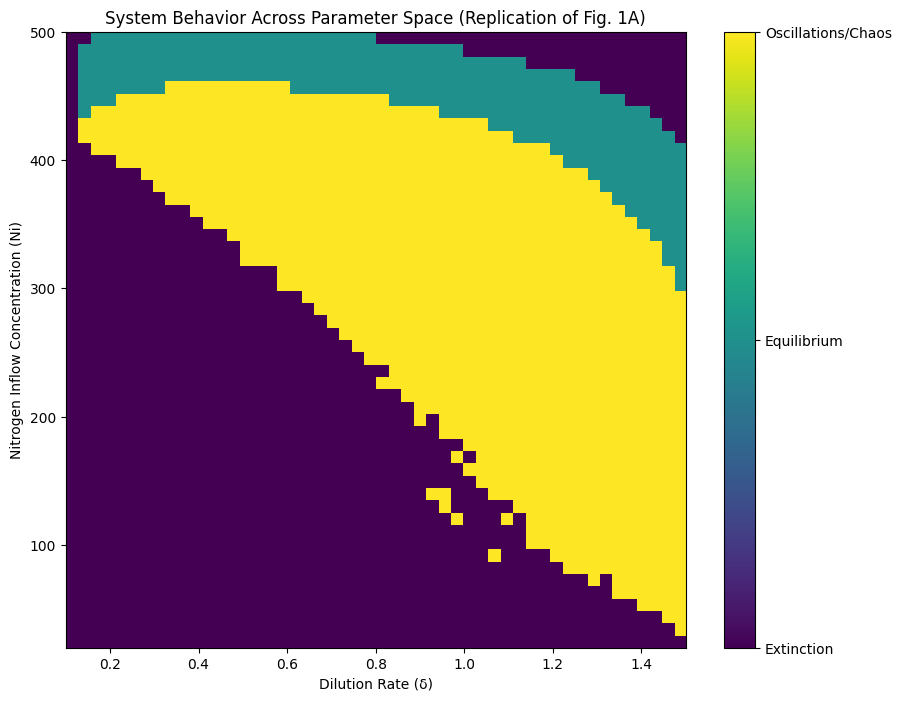

In [ ]:
# --- Plotting the Stability Map ---
plt.figure(figsize=(10, 8))

# We need to flip the stability map for correct orientation with imshow
# and set the origin to 'lower' to have (0,0) at the bottom-left.
plt.imshow(np.flipud(stability_map), cmap='viridis', extent=[delta_range[0], delta_range[-1], Ni_range[0], Ni_range[-1]], aspect='auto', origin='lower')

# --- Add Labels and a Colorbar ---
plt.title('System Behavior Across Parameter Space (Replication of Fig. 1A)')
plt.xlabel('Dilution Rate (δ)')
plt.ylabel('Nitrogen Inflow Concentration (Ni)')

# Create a colorbar with custom labels
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.set_ticklabels(['Extinction', 'Equilibrium', 'Oscillations/Chaos'])

plt.grid(False) # Grid isn't very useful on this type of plot
plt.show()



# You can later load it back with:
# loaded_map = np.load('stability_map_data.npy')